# Laboratorium 07 — Detekcja obiektów — obrazy mikroskopowe krwi (BCCD)

W tym ćwiczeniu zajmiemy się problemem **detekcji obiektów** na obrazach medycznych. Zaimplementujemy od podstaw własną architekturę sieci, która w uproszczony sposób naśladuje działanie modeli typu Faster R-CNN.

**Cele zajęć:**
- Implementacja własnego datasetu dla zadania object detection z augmentacjami.
- Zrozumienie architektury sieci detekcyjnej: **backbone**, **RPN** (Region Proposal Network), **detection head**.
- Poznanie koncepcji **anchor boxes** i ich generowania.
- Implementacja funkcji straty dla detekcji: klasyfikacja obiekt/tło + regresja bounding boxów.
- Trening i ewaluacja modelu z wykorzystaniem metryki **mAP** (mean Average Precision).

**Dataset:**  
**BCCD (Blood Cell Count and Detection)** — zbiór obrazów mikroskopowych krwi z adnotacjami 3 klas komórek: białe krwinki (WBC), czerwone krwinki (RBC) i płytki krwi (Platelets). Zbiór zawiera 364 obrazy z adnotacjami. W notebooku wykorzystujemy bibliotekę **Albumentations** do augmentacji zachowujących spójność pomiędzy obrazem a bounding boxami.

## 0. Środowisko i instalacja pakietów

Przed rozpoczęciem pracy upewnij się, że masz zainstalowane wymagane biblioteki. Jeśli którejś brakuje, odkomentuj i uruchom poniższą komórkę.

In [1]:
# Jeśli brakuje pakietów, odkomentuj i uruchom:
# %pip install -U pip
# %pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
# %pip install pytorch-lightning torchmetrics[detection]
# %pip install albumentations opencv-python matplotlib lxml rich

## 1. Importy i ustawienia

Importujemy niezbędne biblioteki oraz konfigurujemy urządzenie obliczeniowe i precyzję operacji.

In [1]:
import os, random, json
from pathlib import Path
import xml.etree.ElementTree as ET

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image

import pytorch_lightning as pl
from pytorch_lightning import seed_everything

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import numpy as np
import matplotlib.pyplot as plt
from rich import print

from collections import Counter

from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image
from torchvision.models import ResNet18_Weights
import matplotlib.pyplot as plt
import torch

import matplotlib.patches as patches
from torchvision.transforms.functional import to_pil_image

import torchmetrics
import torch.nn as nn
import torch.nn.functional as F
from torchvision.ops import box_iou, nms, roi_align

import math

# seed_everything(42, workers=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Configure TF32 precision
if torch.cuda.is_available():
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    torch.backends.cudnn.benchmark = True
    torch.set_float32_matmul_precision('medium')  # 'medium' or 'high' for speed, 'highest' for accuracy


Using device: cuda

## 2. Pobranie danych

Dane zostaną automatycznie pobrane przez sklonowanie repozytorium GitHub.

In [2]:
root = Path("data/data_bccd")
if not root.exists():
    root.mkdir(parents=True, exist_ok=True)
    exit_code = os.system(f"git clone --depth 1 https://github.com/Shenggan/BCCD_Dataset.git {root}")
    if exit_code != 0:
        print("Uwaga: nie udało się wykonać `git clone`.")
        print("https://github.com/Shenggan/BCCD_Dataset")

ann_dir = root / "BCCD/Annotations"
img_dir = root / "BCCD/JPEGImages"
set_dir = root / "BCCD/ImageSets/Main"

assert ann_dir.exists() and img_dir.exists() and set_dir.exists(), "Brakuje katalogów Annotations/JPEGImages/ImageSets."

xmls = sorted(list((ann_dir).glob("*.xml")))
imgs = sorted(list((img_dir).glob("*.jpg")))
print(f"Liczba adnotacji: {len(xmls)}, liczba obrazów: {len(imgs)}")

Liczba adnotacji: 364, liczba obrazów: 364

## 3. Parser VOC XML i mapowanie etykiet

Format Pascal VOC przechowuje adnotacje obiektów w plikach XML (ścieżka `ann_dir`) i podział na zbiory treningowy, testowy i walidacyjny (ścieżka `set_dir`). Każdy plik XML zawiera informacje o obrazie (rozmiar) oraz listę obiektów z ich współrzędnymi bounding boxów i etykietami klas. Poniżej jest zaimplementowana funkcja która wczytuje dane odnośnie prostokątów otaczających z podanego pliku XML.

W tej sekcji:
- Zdefiniowane są nazwy klas i tworzone mapowania między nazwami a indeksami (indeksy 1-3 dla klas, 0 jest zarezerwowane dla tła).
- Implementowano parser XML, który wydobywa współrzędne prostokątów i etykiety.

In [3]:
CLASS_NAMES = ["WBC", "RBC", "Platelets"]
NAME_TO_IDX = {name: i+1 for i, name in enumerate(CLASS_NAMES)}
IDX_TO_NAME = {i+1: name for i, name in enumerate(CLASS_NAMES)}
NUM_CLASSES = len(CLASS_NAMES) + 1  # + background

def parse_voc_xml(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    size = root.find("size")
    W = int(size.find("width").text)
    H = int(size.find("height").text)
    boxes, labels = [], []
    for obj in root.findall("object"):
        name = obj.find("name").text.strip()
        name = name.replace("Platelet", "Platelets")
        bnd = obj.find("bndbox")
        xmin = float(bnd.find("xmin").text)
        ymin = float(bnd.find("ymin").text)
        xmax = float(bnd.find("xmax").text)
        ymax = float(bnd.find("ymax").text)
        boxes.append([xmin, ymin, xmax, ymax])
        labels.append(NAME_TO_IDX.get(name, 0))
    return np.array(boxes, dtype=np.float32), np.array(labels, dtype=np.int64), (H, W)

## Zadanie 1 – Dataset, augmentacje i DataModule

W tym zadaniu zaimplementujemy klasy do wczytywania danych dla zadania detekcji z datasetu BCCD.

**Kluczowe różnice w porównaniu do klasyfikacji i segmentacji:**
- Dane wyjściowe to nie pojedyncza etykieta ani maska, ale **lista bounding boxów** i **lista etykiet** dla każdego obrazu.
- Augmentacje muszą transformować zarówno obraz jak i współrzędne bounding boxów (np. przy flip'ie musimy też przesunąć współrzędne).
- Używamy biblioteki **Albumentations**, która obsługuje augmentacje dla prostokątów otaczających.

**Dataset (BCCDDataset):**
1. Zaimplementuj klasę `BCCDDataset`, która dziedziczy po `Dataset`.
2. Metoda `__init__`:
   - Pryjmuje i zapamiętuje ścieżki do katalogów z obrazami (`img_dir`) i adnotacjami (`ann_dir`).
   - Kolejnym argumentem jest lista identyfikatorów obrazów (`indices`) — nazwy plików w danym zbiorze.
   - Ostatnim jest obiekt transformacji (`transforms`).
3. W metodzie `__len__` zwróć liczbę próbek.
4. W metodzie `__getitem__`:
   - Argumentem jest indeks pobieranej próbki.
   - Pobierz identyfikator obrazu z listy identyfikatorów na podstawie indeksu.
   - Skonstruuj ścieżki do pliku obrazu (`.jpg`) i adnotacji (`.xml`). Do ścieżek dodaj identyfikator i rozszerzenie.
   - Wczytaj obraz za pomocą `cv2.imread` i przekonwertuj z BGR na RGB.
   - Wczytaj plik z etykietami za pomocą funkcji `parse_voc_xml`.
   - Upewnij się, że wszystkie prostokąty mają poprawne współrzędne (`x2 > x1` i `y2 > y1`). Jeśli nie, odfiltruj niepoprawne boxy.
   - Jeśli `self.transforms` istnieje, zastosuj transformacje przekazując obraz, listę prostokątów oraz listę etykiet. Konwersję do listy wykonaj za pomocą metody `.tolist()`. Albumentations zwraca słownik z kluczami `"image"`, `"bboxes"`, `"class_labels"`.
   - Skonwertuj wynikowe prostokąty i etykiety z powrotem na `np.array`.
   - Przygotuj słownik `target` z kluczami:
     - `"boxes"` — tensor typu `float32` z bounding boxami.
     - `"labels"` — tensor typu `int64` z etykietami klas.
     - W formacie COCO są jeszcze dodatkowe pola (`"image_id"`, `"area"`, `"iscrowd"`), ale nie są one w naszej implementacji potrzebne.
   - Zwróć obrazy i docelowe prostokąty.

**Funkcja collate:**
1. Funkcja ta mówi w jaki sposób wczytane dane mają być łączone w batch. Dla zadania detekcji w kolejnych próbkach liczba prostokątów może być różna, więc łatwiej może być te dane połączyć w listę, zamiast tensor.
2. Zaimplementuj funkcję `collate_fn(batch)`:
   - Rozpakuj obrazy i targety: `imgs, targets = list(zip(*batch))` do dwóch osobnych list.
   - Zwróć te listy.

**DataModule (BCCDDataModule):**
1. Zaimplementuj klasę `BCCDDataModule`, która dziedziczy po `pl.LightningDataModule`.
2. Argumentami metody `__init__` są ścieżki do katalogów z obrazami, adnotacjami i podziałem zbiorów, rozmiar batcha i liczba workerów:
   - Zapamiętaj przekazane argumenty.
   - Zdefiniuj transformacje treningowe za pomocą `A.Compose`:
     - `A.RandomBrightnessContrast` — losowa zmiana jasności i kontrastu, jako argument przekaż prawdopodobieństwo,
     - `A.HorizontalFlip()` — losowe odbicie poziome, jako argument przekaż prawdopodobieństwo,
     - `A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))` — gdy nie używamy pretrenowanych wag do ResNet, `A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))` gdy używamy,
     - `A.ToTensorV2()` — konwersja do tensora PyTorch,
     - Przekaż `bbox_params=A.BboxParams(format="pascal_voc", label_fields=["class_labels"])` jako argument dla funkcji `A.Compose`, aby Albumentations wiedziało jak modyfikować prostokąty.
   - Zdefiniuj transformacje walidacyjne analogicznie, ale bez augmentacji (tylko `A.NoOp()`, normalizacja i konwersja do tensora).
3. Zaimplementuj metodę pomocniczą, która przyjmuje plik podziału na zbiory jako argument:
   - Zwróć listę identyfikatorów (każda linia to jedna nazwa pliku):
   `with open(split_path, 'r') as f: ids = [line.strip() for line in f if line.strip()]`
4. W metodzie `setup(self, stage=None)`:
   - Wczytaj identyfikatory dla train, val i test używając zaimplementowanej metody pomocniczej.
   - Stwórz trzy datasety za pomocą zaimplementowanej wcześniej klasy, przekazując odpowiednie katalogi, identyfikatory i transformacje.
   - Wyświetl rozmiary zbiorów.
5. Zaimplementuj metody `train_dataloader()`, `val_dataloader()`, `test_dataloader()`:
   - Zwróć `DataLoader` z odpowiednim datasetem.
   - Ustaw `shuffle` tylko dla train.
   - Przekaż rozmiar batcha i liczbę workerów.
   - Ustaw `collate_fn=collate_fn`.

**Poza klasami:**
1. Stwórz instancję `BCCDDataModule` z odpowiednimi ścieżkami i parametrami.
2. Wywołaj `setup()`.
3. Pobierz dataloadery z zaimplementowanej ze stworzonej instancji.

In [4]:
class BCCDDataset(Dataset):
    def __init__(self, img_dir, ann_dir, indices, transforms=None):
        self.img_dir = Path(img_dir)
        self.ann_dir = Path(ann_dir)
        self.indices = indices
        self.transforms = transforms

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        img_id = self.indices[idx]

        img_path = self.img_dir / f"{img_id}.jpg"
        ann_path = self.ann_dir / f"{img_id}.xml"

        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        boxes, labels, (H, W) = parse_voc_xml(ann_path)

        # fiter bad bboxes
        good = []
        for i, (xmin, ymin, xmax, ymax) in enumerate(boxes):
            if xmax > xmin and ymax > ymin:
                good.append(i)
        boxes = boxes[good]
        labels = labels[good]

        # augmentations
        if self.transforms:
            transformed = self.transforms(
                image=img,
                bboxes=boxes.tolist(),
                class_labels=labels.tolist()
            )
            img = transformed["image"]
            boxes = np.array(transformed["bboxes"], dtype=np.float32)
            labels = np.array(transformed["class_labels"], dtype=np.int64)

        # build target
        target = {
            "boxes": torch.tensor(boxes, dtype=torch.float32),
            "labels": torch.tensor(labels, dtype=torch.int64)
        }

        return img, target


In [5]:
def collate_fn(batch):
    imgs, targets = list(zip(*batch))
    return list(imgs), list(targets)

In [6]:
class BCCDDataModule(pl.LightningDataModule):
    def __init__(self, img_dir, ann_dir, split_dir,
                 batch_size=4, num_workers=4):
        super().__init__()
        self.img_dir = Path(img_dir)
        self.ann_dir = Path(ann_dir)
        self.split_dir = Path(split_dir)
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.train_transforms = A.Compose(
            [
                A.RandomBrightnessContrast(p=0.5),
                A.HorizontalFlip(p=0.5),
                A.Normalize(mean=(0.5, 0.5, 0.5),
                            std=(0.5, 0.5, 0.5)),
                ToTensorV2(),
            ],
            bbox_params=A.BboxParams(
                format="pascal_voc",
                label_fields=["class_labels"]
            )
        )
        self.val_transforms = A.Compose(
            [
                A.Normalize(mean=(0.5, 0.5, 0.5),
                            std=(0.5, 0.5, 0.5)),
                ToTensorV2(),
            ],
            bbox_params=A.BboxParams(
                format="pascal_voc",
                label_fields=["class_labels"]
            )
        )

    def load_ids(self, split_file):
        with open(split_file, "r") as f:
            ids = [line.strip() for line in f if line.strip()]
        return ids

    def setup(self, stage=None):
        train_ids = self.load_ids(self.split_dir / "train.txt")
        val_ids   = self.load_ids(self.split_dir / "val.txt")
        test_ids  = self.load_ids(self.split_dir / "test.txt")

        self.train_dataset = BCCDDataset(
            self.img_dir, self.ann_dir,
            indices=train_ids,
            transforms=self.train_transforms
        )
        self.val_dataset = BCCDDataset(
            self.img_dir, self.ann_dir,
            indices=val_ids,
            transforms=self.val_transforms
        )
        self.test_dataset = BCCDDataset(
            self.img_dir, self.ann_dir,
            indices=test_ids,
            transforms=self.val_transforms
        )

        print(f"Train: {len(self.train_dataset)}, Val: {len(self.val_dataset)}, Test: {len(self.test_dataset)}")

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            collate_fn=collate_fn
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            collate_fn=collate_fn
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            collate_fn=collate_fn
        )


In [7]:
datamodule = BCCDDataModule(
    img_dir=img_dir,
    ann_dir=ann_dir,
    split_dir=set_dir,
    batch_size=4,
    num_workers=4
)

datamodule.setup()

train_loader = datamodule.train_dataloader()
val_loader = datamodule.val_dataloader()
test_loader = datamodule.test_dataloader()

next(iter(train_loader))

/home/karolina/studia/piaom/venv/lib/python3.12/site-packages/albumentations/core/composition.py:331: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()


Train: 205, Val: 87, Test: 72

([tensor([[[0.5137, 0.5373, 0.5608,  ..., 0.3333, 0.3255, 0.3255],
           [0.5059, 0.5294, 0.5529,  ..., 0.3412, 0.3333, 0.3255],
           [0.5137, 0.5373, 0.5451,  ..., 0.3490, 0.3333, 0.3176],
           ...,
           [0.4588, 0.4667, 0.4745,  ..., 0.5451, 0.5451, 0.5529],
           [0.4510, 0.4588, 0.4667,  ..., 0.5451, 0.5451, 0.5529],
           [0.4510, 0.4588, 0.4667,  ..., 0.5451, 0.5451, 0.5529]],
  
          [[0.4667, 0.4902, 0.5137,  ..., 0.2549, 0.2314, 0.2314],
           [0.4588, 0.4824, 0.5059,  ..., 0.2627, 0.2392, 0.2314],
           [0.4431, 0.4667, 0.4980,  ..., 0.2706, 0.2392, 0.2235],
           ...,
           [0.3333, 0.3412, 0.3490,  ..., 0.5529, 0.5529, 0.5608],
           [0.3255, 0.3333, 0.3412,  ..., 0.5529, 0.5529, 0.5608],
           [0.3255, 0.3333, 0.3412,  ..., 0.5529, 0.5529, 0.5608]],
  
          [[0.4980, 0.5216, 0.5451,  ..., 0.2392, 0.2314, 0.2314],
           [0.4902, 0.5137, 0.5373,  ..., 0.2471, 0.2392, 0.2314],
           [0.4667, 0.

## Zadanie 2 – Wizualizacja próbek z bounding boxami

Wyświetl kilka próbek ze zbioru treningowego razem z zaznaczonymi prostokątami otaczającymi.

1. Pobierz batch za pomocą `imgs, tgts = next(iter(dloader))`.
2. W pętli pobierz prostokąty i etykiety dla kolejnych próbek: `tgts[i]["boxes"]` i `tgts[i]["labels"]`.
3. Skonwertuj etykietę do nazwy za pomocą słownika `IDX_TO_NAME`: `labels_txt = [f"{IDX_TO_NAME.get(l.item(),'BG')}" for l in labels]`
4. Wygeneruj obraz z zaznaczonymi obiektami za pomocą funkcji `draw_bounding_boxes`. Przekaż jej obraz wejściowy, prostokąty i etykiety.
5. Wyświetl wynikowy obraz.

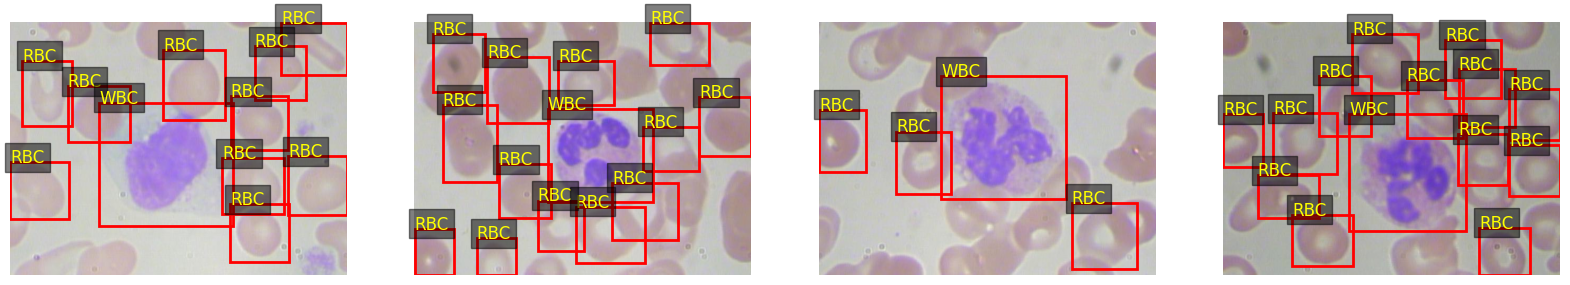

In [8]:
imgs, tgts = next(iter(train_loader))

num = len(imgs)
fig, axes = plt.subplots(1, num, figsize=(5 * num, 5))

if num == 1:
    axes = [axes]

for ax, img, tgt in zip(axes, imgs, tgts):
    boxes = tgt["boxes"]
    labels = tgt["labels"]
    labels_txt = [f"{IDX_TO_NAME.get(l.item(), 'BG')}" for l in labels]

    # CHW -> HWC
    img_np = img.permute(1, 2, 0).numpy()
    
    # denormalization
    img_np = (img_np * 0.5 + 0.5).clip(0, 1)

    ax.imshow(img_np)
    ax.axis("off")

    for (xmin, ymin, xmax, ymax), lab in zip(boxes, labels_txt):
        rect = patches.Rectangle(
            (xmin, ymin),
            xmax - xmin,
            ymax - ymin,
            linewidth=2,
            edgecolor='red',
            facecolor='none'
        )
        ax.add_patch(rect)
        ax.text(
            xmin,
            ymin,
            lab,
            color="yellow",
            fontsize=12,
            bbox=dict(facecolor="black", alpha=0.5)
        )

plt.show()

## Implementacja architektury sieci do detekcji

W kolejnych zadaniach zaimplementujemy architekturę sieci składającą się z czterech głównych komponentów: **Anchor Generator**, **Region Proposal Network**, **Detection Head** i **Detector** łączącego wszystko razem.

### Zadanie 3 – Anchor Generator

Anchor boxes to predefiniowane bounding boxy o różnych rozmiarach i proporcjach, które służą jako punkt odniesienia dla sieci. Dla każdej pozycji na feature mapie generujemy zestaw anchorów o różnych rozmiarach i kształtach.

1. Zaimplementuj klasę `AnchorGenerator`, która dziedziczy po `nn.Module`:
   - Konstruktorze przyjmuje i zapamiętuje listę rozmiarów anchorów (`sizes`) i proporcji boków (`aspect_ratios`).
   - Oblicz liczbę anchorów przypadających na jeden element z macierzy cech jako iloczyn liczby rozmiarów i liczby proporcji.
2. Zaimplementuj metodę `generate_anchors(self, feature_size, image_size, device)`:
   - Przyjmuje rozmiar mapy cech `(H, W)` i rozmiar obrazu `(img_h, img_w)`.
   - Oblicz stride (na ile pikseli w obrazie wejściowym przypada jedno pole mapy cech): `stride_h = img_h / h`, `stride_w = img_w / w`.
   - Wygeneruj współrzędne centrów anchorów dla każdej pozycji mapy cech mnożąc wektor `torch.arange(0, h, device=device, dtype=torch.float32)` przez stride i dodając połowę rozmiaru.
   - Stwórz dwuwymiarowe mapy tych współrzędnych za pomocą `torch.meshgrid(shifts_y, shifts_x, indexing='ij')`, a następnie spłaszcz je za pomocą metody `.reshape(-1)`.
   - Stwórz pustą listę na anchory.
   - Dla każdej kombinacji rozmiaru i proporcji (w pętli):
     - Oblicz wysokość i szerokość anchorów: `h_anchor = size / sqrt(aspect_ratio)`, `w_anchor = size * sqrt(aspect_ratio)`.
     - Dla każdego centrum oblicz współrzędne `(x1, y1, x2, y2)` anchora.
     - Połącz te współrzędne za pomocą `torch.stack` wzdłów wymiaru `dim=1`.
     - Dodaj macierz współrzędnych do listy anchorów (metoda `.append`).
   - Połącz wszystkie anchory w jeden tensor za pomocą metody `.cat` wzdłuż wymiaru `dim=0`.
   - Przytnij anchory do granic obrazu używając `torch.clamp`.
   - Zwróć tensor anchorów. Jego kształt to `[num_anchors*H*W, 4]`.

In [9]:
class AnchorGenerator(nn.Module):
    def __init__(self, sizes, aspect_ratios):
        """
        sizes: lista skal anchorów, np. [32, 64, 128]
        aspect_ratios: lista proporcji boków, np. [0.5, 1.0, 2.0]
        """
        super().__init__()
        self.sizes = sizes
        self.aspect_ratios = aspect_ratios
        self.num_anchors_per_position = len(sizes) * len(aspect_ratios)

    def generate_anchors(self, feature_size, image_size, device):
        """
        feature_size: (H, W) — rozmiar mapy cech
        image_size: (img_h, img_w) — rozmiar oryginalnego obrazu
        """

        H, W = feature_size
        img_h, img_w = image_size

        stride_h = img_h / H
        stride_w = img_w / W

        shifts_y = torch.arange(0, H, dtype=torch.float32, device=device) * stride_h + stride_h / 2
        shifts_x = torch.arange(0, W, dtype=torch.float32, device=device) * stride_w + stride_w / 2

        shift_y, shift_x = torch.meshgrid(shifts_y, shifts_x, indexing='ij')

        shift_x = shift_x.reshape(-1)
        shift_y = shift_y.reshape(-1)

        centers = torch.stack([shift_x, shift_y], dim=1)  # [H*W, 2]

        all_anchors = []

        for size in self.sizes:
            for ar in self.aspect_ratios:

                h_anchor = size / math.sqrt(ar)
                w_anchor = size * math.sqrt(ar)

                x1 = centers[:, 0] - w_anchor / 2
                y1 = centers[:, 1] - h_anchor / 2
                x2 = centers[:, 0] + w_anchor / 2
                y2 = centers[:, 1] + h_anchor / 2

                anchors = torch.stack([x1, y1, x2, y2], dim=1)
                all_anchors.append(anchors)

        anchors = torch.cat(all_anchors, dim=0)

        anchors = torch.clamp(anchors, min=0)
        anchors[:, 0] = torch.clamp(anchors[:, 0], max=img_w)
        anchors[:, 2] = torch.clamp(anchors[:, 2], max=img_w)
        anchors[:, 1] = torch.clamp(anchors[:, 1], max=img_h)
        anchors[:, 3] = torch.clamp(anchors[:, 3], max=img_h)

        return anchors

In [10]:
gen = AnchorGenerator(
    sizes=[32, 64, 128],
    aspect_ratios=[0.5, 1.0, 2.0]
)

anchors = gen.generate_anchors(
    feature_size=(50, 50),
    image_size=(800, 800),
    device="cpu"
)

print(anchors.shape)  # [H*W * num_sizes * num_ratios, 4]

torch.Size([22500, 4])

### Zadanie 4 - Region Proposal Network

RPN to sieć, która dla każdego anchora przewiduje czy zawiera obiekt (objectness) i korekty współrzędnych anchorów (bbox deltas).

1. Zaimplementuj klasę `RPN`, która dziedziczy po `nn.Module`:
   - Konstruktor przyjmuje liczbę warstw (cech) i liczbę anchorów:
     - Stwórz warstwę konwolucyjną (3x3, padding=1) przetwarzającą cechy. Wejście i wyjście ma tę samą liczbę kanałów.
     - Stwórz warstwę konwolucyjną (1x1) przewidującą prawdopodobieństwo obiektu dla każdego anchora. Na wyjściu liczba kanałów jest równa liczbie anchorów.
     - Stwórz warstwę konwolucyjną (1x1) przewidującą 4 delty dla każdego anchora. Na wyjściu liczba kanałów jest równa liczbie anchorów pomnożonej przez 4.
2. W metodzie `forward(self, features)`:
   - Przepuść cechy przez pierwszą warstwę konwolucyjną i aktywację ReLU (`F.relu`).
   - Wyjście pierwszej warstwy przepuść przez dwie pozostałe.
   - Przekształć objectness do odpowiedniego kształtu `.permute(0, 2, 3, 1).reshape(batch_size, -1)`.
   - Przekształć bbox_deltas do odpowiedniego kształtu `.permute(0, 2, 3, 1).reshape(batch_size, -1, 4)`.
   - Zwróć objectness i bbox_deltas.

In [11]:
class RPN(nn.Module):
    def __init__(self, in_channels, num_anchors):
        """
        in_channels: liczba kanałów mapy cech z backbone'u
        num_anchors: liczba anchorów przypadających na jedną pozycję (np. 9)
        """
        super().__init__()

        self.conv = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.objectness_pred = nn.Conv2d(in_channels, num_anchors, kernel_size=1)
        self.bbox_pred = nn.Conv2d(in_channels, num_anchors * 4, kernel_size=1)

    def forward(self, features):
        """
        features: tensor [B, C, H, W]
        """
        B, C, H, W = features.shape

        t = self.conv(features)
        t = F.relu(t)

        objectness = self.objectness_pred(t)     # [B, num_anchors, H, W]
        bbox_deltas = self.bbox_pred(t)          # [B, num_anchors*4, H, W]

        # objectness: [B, H*W*num_anchors]
        # bbox_deltas: [B, H*W*num_anchors, 4]
        objectness = objectness.permute(0, 2, 3, 1).reshape(B, -1)
        bbox_deltas = bbox_deltas.permute(0, 2, 3, 1).reshape(B, -1, 4)

        return objectness, bbox_deltas

In [12]:
features = torch.randn(2, 256, 50, 50)

rpn = RPN(in_channels=256, num_anchors=9)

obj_logits, deltas = rpn(features)

print(obj_logits.shape)   # [2, 50*50*9]
print(deltas.shape)       # [2, 50*50*9, 4]

torch.Size([2, 22500])

torch.Size([2, 22500, 4])

### Zadanie 5 - Detection Head

Head przyjmuje cechy z ROI i przewiduje finalną klasę obiektu oraz korekty prostokątów otaczających. Rozmiar batcha dla tek klasy jest równy liczbie prostokątów dla których wykonywana jest predykcja.

1. Zaimplementuj klasę `DetectionHead`, która dziedziczy po `nn.Module`:
   - Konstruktor przyjmuje liczbę kanałów (cech) i liczbę klas:
     - Stwórz dwie warstwy w pełni połączone. Liczba kanałów na wejściu pierwszej jest równa liczbie cech pomnożononej przez rozmiar przestrzenny tensora cech. Dla ResNet jako backbone jest to `in_channels * 7 * 7`. Dobierz pozostałe liczby kanałów.
     - Stwórz w pełni połączoną warstwę klasyfikacji. Liczba kanałów na wyjściu jest równa liczbie klas.
     - Stwórz w pełni połączoną warstwę regresji prostokątów. Liczba kanałów na wyjściu jest równa 4.
2. W metodzie `forward(self, roi_features)`:
   - Spłaszcz cechy ROI: `x = roi_features.flatten(start_dim=1)`.
   - Przepuść przez dwie pierwsze warstwy w pełni połączone.
   - Oblicz logity klas i korekty prostokątów za pomocą dwóch pozostałych warstw.
   - Zwróć logity i korekty prostokątów otaczających.

In [13]:
class DetectionHead(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.flatten_dim = in_channels * 7 * 7
        self.fc1 = nn.Linear(self.flatten_dim, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.cls_score = nn.Linear(1024, num_classes)
        self.bbox_pred = nn.Linear(1024, 4)

    def forward(self, roi_features):
        x = roi_features.flatten(start_dim=1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        class_logits = self.cls_score(x)   # [N, num_classes]
        bbox_deltas = self.bbox_pred(x)    # [N, 4]

        return class_logits, bbox_deltas

In [14]:
N = 20
C = 256
num_classes = 4

roi_feats = torch.randn(N, C, 7, 7)

head = DetectionHead(in_channels=C, num_classes=num_classes)
class_logits, deltas = head(roi_feats)

print(class_logits.shape)   # [20, 4]
print(deltas.shape)         # [20, 4]

torch.Size([20, 4])

torch.Size([20, 4])

### Zadanie 6 - Detektor

To główna klasa łącząca backbone, anchor generator, RPN i detection head w kompletny model detekcji. Z uwagi na dużą ilość potrzebnego kodu, część potrzebnych funkcjonalności jest już zaimplementowana.

1. Zaimplementuj klasę `Detector`, która dziedziczy po `nn.Module`:
   - W konstruktorze (już zaimplementowany):
     - Załaduj backbone (ResNet18 bez ostatnich warstw FC): `self.backbone = nn.Sequential(*list(resnet.children())[:-2])`.
     - Stwórz instancję `AnchorGenerator` z odpowiednimi parametrami.
     - Stwórz instancję `RPN` z liczbą kanałów backbonu i liczbą anchorów.
     - Stwórz instancję `DetectionHead`.
     - Zdefiniuj hiperparametry treningu i inferencji (progi IoU, NMS, rozmiary batchy, itp.).

2. Zaimplementuj metody pomocnicze do kodowania/dekodowania bounding boxów:
   - `_xyxy_to_cxcywh(boxes)`:
     - rozłóż wejściowy wektor na składowe (`x1, y1, x2, y2 = boxes.unbind(-1)`),
     - oblicz szerokość i wysokość,
     - oblicz współrzędne środka,
     - połącz obliczone wielkości za pomocą `torch.stack` wzdłóż ostatniego wymiaru `dim=-1`,
     - zwróć stworzony wektor.
   - `_cxcywh_to_xyxy(boxes)`:
     - rozłóż wejściowy wektor na składowe (`cx, cy, w, h = boxes.unbind(-1)`),
     - oblicz współrzędne zewnętrzne prostokąta otaczającego,
     - połącz obliczone wielkości za pomocą `torch.stack` wzdłóż ostatniego wymiaru `dim=-1`,
     - zwróć stworzony wektor.
   - `encode_boxes(target_boxes, reference_boxes)`:
     - przekształca współrzędne wyznaczonych prostokątów na korekty względem prostokątów referencyjnych,
     - zamieneń współrzędne zewnętrzne do współrzędnych środka, szerokości i wysokości za pomocą wcześniejszej funkcji,
     - oblicz relatywne przesunięcie środków: $(xc_t - xc_r)/w_r$, $(yc_t - yc_r)/h_r$,
     - oblicz logarytmiczną skalę: $log(w_t / w_r)$, $log(h_t / h_r)$ (dodaj zabezpieczenie przed zbyt małą wartością argumentu `.clamp(min=1e-6)`),
     - połącz obliczone wielkości za pomocą `torch.stack` wzdłóż wymiaru `dim=1`,
     - zwróć stworzony wektor.
   - `decode_boxes(deltas, reference_boxes)`:
     - odwrotna operacja, przekształca delty (dx, dy, dw, dh) na współrzędne prostokątów,
     - zamień współrzędne zewnętrzne do współrzędnych środka, szerokości i wysokości,
     - oblicz współrzędne środka: $dx * w_r + xc_r$, $dy * h_r + yc_r$,
     - oblicz wysokość i szerokość: $w_r * exp(dw)$, $h_r * exp(dh)$
     - połącz obliczone wielkości za pomocą `torch.stack` wzdłóż ostatniego wymiaru`dim=-1`,
     - Skonwertuj stworzony wektor do współrzędnych zewnętrznych (zaimplementowana wcześniej funkcja),
     - zwróć stworzony wektor.
   - `clip_boxes_to_image(boxes, img_h, img_w)`:
     - przycina współrzędne do granic obrazu,
     - zastosuj metodę `.clamp`.

3. W metodzie `forward(self, images, targets=None)`:
   - Złóż obrazy w batch (`torch.stack`) i przepuść przez backbone aby uzyskać mapy cech.
   - Wygeneruj anchory dla danego rozmiaru mapy cech (metoda `generate_anchors`).
   - Przepuść cechy przez RPN aby uzyskać prawdopodobieństwa obiektów i korekty anchorów.
   - Jeśli `self.training` i przekazano `targets`:
     - Wywołaj metodę i zwróć wynik `self._compute_loss(objectness, bbox_deltas, anchors, features, targets, batch_size, img_h, img_w)` aby obliczyć straty.
   - W przeciwnym razie:
     - Wywołaj metodę i zwróć wynik `self._inference(objectness, bbox_deltas, anchors, features, batch_size, img_h, img_w)` aby wygenerować finalne predykcje.

4. Zaimplementuj pomocniczą metodę `_sample_regions(self, pos_mask, neg_mask, batch_size, pos_fraction)`:
   - Ma ona wyznaczyć losowe podzbiory z wyznaczonych prostokątów, jeśli jest ich zbyt dużo. `batch_size` jest maksymalną liczbą próbek. `pos_fraction` jest pozytywną częścią próbek.
   - Znajdź wszystkie indeksy pozytywnych próbek (`pos_mask`) używając `torch.nonzero(pos_mask, as_tuple=False).squeeze(1)`.
   - Wykonaj to samo dla negatywnych próbek.
   - Oblicz liczbę pozytywnych próbek do wylosowania: `num_pos = int(batch_size * pos_fraction)`.
   - Jeśli liczba dostępnych pozytywnych próbek jest większa niż `num_pos`, wylosuj `num_pos` indeksów używając `torch.randperm`. Jej pierwszym argumentem jest liczba próbek, a drugim urządzenie na którym wykonywane są obliczenia. Następnie wybieramy `num_pos` początkowych elementów wyniku. Na podstawie tych elementów  wybieramy później indeksy pozytywnych próbek. 
   - W przeciwnym razie użyj wszystkich dostępnych pozytywnych próbek.
   - Oblicz maksymalną liczbę negatywnych próbek jako `batch_size` pomniejszone o liczbę wylosowanych pozytywnych próbek.
   - Jeśli liczba dostępnych negatywnych próbek jest większa niż maksymalna liczbę negatywnych próbek, wylosój indeksy podobnie jak wcześniej dla pozytywnych.
   - W przeciwnym razie użyj wszystkich dostępnych negatywnych próbek.
   - Zwróć cztery tensory: wylosowane pozytywne indeksy, wylosowane negatywne indeksy, wszystkie pozytywne indeksy, wszystkie negatywne indeksy.

5. Zaimplementuj metodę `_compute_loss(self, objectness, bbox_deltas, anchors, features, targets, batch_size, img_h, img_w)`:
   - Dla każdego obrazu w batchu:
     - **RPN loss:**
       - Oblicz IoU między anchorami a ground truth boxami. Użyj funkcji `box_iou`. Jej pierwszym argumentem są współrzędne anchorów `anchors`, a drugim prostokąty otaczające danej próbki `gt_boxes`.
       - Wyznacz maksymalne IoU dla każdego anchora `max_iou, matched_gt_idx = ious.max(dim=1)`.
       - Stwórz maskę pozytywnych anchorów (`max_iou` większe od `rpn_fg_iou_thresh`)
       - Stwórz maskę negatywnych anchorów (`max_iou` mniejsze od `rpn_bg_iou_thresh`)
       - Wyznacz próbki, które zostaną wykorzystane do funkcji straty dla objectness za pomocą metody `self._sample_regions`. Dwoma pierwszymi argumentami są wyznaczone maski. Kolejnymi są `rpn_batch_size` i `rpn_positive_fraction`.
       - Połącz indeksy wyosowanych pozytywnych i negatywnych próbek za pomocą `torch.cat` wzdłóż wymiaru `dim=0`.
       - Stwórz tensor docelowego objectness. Wykorzystaj `torch.zeros_like`, a jako argument podaj objectness wyznaczone z RPN dla danej próbki. Następnie wartości pod elementami z maski pozytywnych elementów zamień na `1.0`.
       - Wybierz wartości z objectness RPN i wyznaczonych targetów spod wylosowanych indeksów.
       - Oblicz stratę objectness za pomocą `F.binary_cross_entropy_with_logits`. Dodaj ją do listy `rpn_cls_losses`.
       - Następnie wyznacz docelowe korekty anchorów za pomocą metody `encode_boxes`. Pierwszym argumentem są prostokąty otaczające odpowiadające wszystkim anchorom oznaczonym jako pozytywne `gt_boxes[matched_gt_idx[all_pos_idx]]`, a drugim same pozytywne anchory `anchors[all_pos_idx]`.
       - Wyznacz korekty z wyjścia sieci dla pozytywnych anchorów `bbox_deltas[i][all_pos_idx]`.
       - Oblicz stratę dla korekt prostokątów za pomocą `F.smooth_l1_loss`. Przekaż dodatkowo parametr `reduction='mean'`.
       - Dodaj obliczoną stratę do listy `rpn_reg_losses`.
     - **Detection head loss:**
       - Wybierz propozycje ROI dla head (z wyłączonym obliczaniem gradientu) `with torch.no_grad():`
       - Oblicz skorygowane prostokąty na podstawie wyników z RPN za pomocą funkcji `self.decode_boxes`. Pierwszym argumentem są korekty dla danej próbki z RPN, a drugim współrzędne anchorów.
       - Przytnij współrzędne prostokątów do rozmiaru obrazu za pomocą metody `clip_boxes_to_image`.
       - Skonwertuj wyniki objectness do prawdopodobieństwa za pomocą `torch.sigmoid`.
       - Następnie chcemy pozbyć się nakładających się prostokątów, które nie są lokalnym maksimum prawdopodobieństwa. W tym celu wykorzystaj funkcję `nms`. Jej pierwszym argumentem są skorygowane prostokąty otaczające, drugim ich prawdopodobieństwa, a trzecim parametr `rpn_nms_thresh`. Wyjściem jest maska o takiej liczbie elementów jak wejściowe prostokąty.
       - Wybierz prostokąty i prawdopodobieństwa na podstawie wyniku NMS.
       - Jeśli liczba prostokątów jest większa niż `box_nms_num_keep`, to wybierz `box_nms_num_keep` o największym prawdopodobieństwie (jeśli nie, to chcemy je po prostu posortować). Wykorzystaj funkcję `torch.topk` i pobierz indeksy z wyniku za pomocą pola `.indices`. Pierwszym argumentem są prawdopodobieństwa po NMS, a drugim liczba prostokątów, które chcemy.
       Następnie posortuj prostokąty za pomocą otrzymanych indeksów.
       - Kolejne obliczenia są już wykonywane z obliczaniem gradientów (poza blokiem `box_nms_num_keep`).
       - Oblicz IoU posortowanych prostokątów względem docelowych prostokątów dla danej próbki za pomocą funkcji `box_iou`. 
       - Następnie sprawdzamy maksymalne IoU dla każdego prostokąta (wzdłuż wymiaru `dim=1`).
       - Sprawdzamy pozytywne i negatywne prostokąty za pomocą parametrów `roi_fg_iou_thresh` i `roi_bg_iou_thresh` podobnie jak przed RPN.
       - Jeśli prostokątów pozytywnych lub negatywnych jest zbyt dużo to chcemy wylosować założoną liczbę, podobnie jak przed obliczaniem straty dla objectness dla RPN, za pomocą metody `_sample_regions`. W tym wypadku wykorzystaj parametry `roi_batch_size` i `roi_positive_fraction`.
       - Również połącz przefiltrowane indeksy pozytywne i negatywne w jeden tensor za pomocą `torch.cat` wzdłóż zerowego wymiaru.
       - Na podstawie stworzonego tensora z indeksami wybierz prostokąty, odpowiadające im indeksy prostokątów docelowych (drugi wynik wcześniej obliczanego maksimum IoU), a następnie etykiety docelowe dla danych prostokątów (tutaj dodatkowo chcemy je skopiować za pomocą metody `.clone()`).
       - Wybrane docelowe etykiety musimy dodatkowo zmodyfikować. Jeśli dany prostokąt został sklasyfikowany jako negatywny to docelową etykietę chcemy zmienić na 0. W tym celu warto sprawdzić ile było etykiet pozytywnych na wyjściu metody `_sample_regions`.
       - Do head musimy przekazać cechy odpowiadające wyznaczonym prostokątom. Chcemy je wyliczyć z przekazanej mapy cech za pomocą interpolacji biliniowej na podstawie współrzędnych prostokątów w obrazie wejściowym. W tym celu wykorzystujemy funkcję `roi_align`. Pierwszym argumentem jest mapa cech odpowiadająca przetwarzanej próbce `features[[i]]` (podwójny nawias zachowuje wymiar batcha), a drugim lista tensorów `[sel_props]` zawierająca wylosowane wcześniej prostokąty (dane są przekazywane jako lista, bo funkcja pozwala na obliczenia dla wielu próbek w batchu). Trzecim argumentem (`output_size`) jest rozmiar przestrzenny mapy cech, a czwartym (`spatial_scale`) skala obliczona na początku metody.
       - Oblicz wyjścia head dla przeskalowanych cech prostokątów, obliczając prawdopodobieństwa dla klas i dodatkowe korekcje prostokątów.
       - Teraz oblicz stratę klasyfikacji prostokątów za pomocą head `F.cross_entropy`. Przekaż jej wynik klasyfikacji i docelowe etykiety. Zastosuj również `label_smoothing=self.label_smoothing`. Dodaj obliczoną stratę do listy `roi_cls_losses`.
       - Następnie chcemy obliczyć stratę korekt prostokątów otaczających z head dla sklasyfikowanych wcześniej jako pozytywne.
       - Wybierz prostokąty oznaczone wcześniej jako pozytywne (np. na podstawie liczebności pozytywnych indeksów na wyjściu z losowania prostokątów).
       - Wybierz również odpowiadajce im współrzędne docelowe.
       - Skonwertuj wybrane prostokąty i współrzędne docelowe do korekt za pomocą metody `encode_boxes`.
       - Wybierz również wyjściowe korekty z head odpowiadające pozytywnym próbkom.
       - Oblicz stratę korekt z head za pomocą `F.smooth_l1_loss`. Przekaż wybrane korekty z head oraz odpowiadające docelowe korekty. Dodatkowo przekaż `reduction='mean'`.
       - Wynik dodaj do listy `roi_reg_losses`.
   - Na koniec (poza pętlą dla batcha) łączymy obliczone straty w jedną wartość (już zaimplementowane) i zwracamy słownik.

6. Zaimplementuj metodę `_inference(self, objectness, bbox_deltas, anchors, features, batch_size, img_h, img_w)`:
   - Dla każdego obrazu w batchu (w pętli):
     - Skonwertuj objectness do prawdopodobieństw `torch.sigmoid`.
     - Zamień korekty z RPN do prostokątów otaczających za pomocą metody `decode_boxes`.
     - Przytnij wyznaczone prostokąty do rozmiaru obrazu za pomocą `clip_boxes_to_image`.
     - Wyznacz indeksy prostokątów o największym prawdopodobieństwie obiektu i posortuj je. Chcemy przetwarzać dalej maksymalnie `box_nms_num_inf_keep` prostokątów. Posortuj i wybierz indeksy o największym prawdopodobieństwie za pomocą funkcji `torch.topk`. Wybierz i posortuj prostokąty na podstawie wyjścia tej funkcji.
     - Dalej filtrujemy nakładające się prostokątny o niemaksymalnym prawdopodobieństwie za pomocą funkcji `nms` podobnie jak podczas treningu. Wykorzystujemy parametr `rpn_nms_thresh`. Wybieramy prostokąty i prawdopodobieństwa na podstawie otrzymanej maski.
     - Interpolujemy cechy dla prostokątów podobnie jak w treningu za pomocą funkcji `roi_align`. Wynik przekazujemy do head.
     - Wynik klasyfikacji head przekazujemy do `F.softmax`. Podajemy dodatkowo wymiar `dim=1`. Wybieramy również maksima wzdłuż tego wymiaru. W ten sposób obliczyliśmy docelową klasę dla każdego zaproponowanego prostokąta.
     - Następnie wykorzystujemy korekcje z head do poprawy prostokątów z RPN za pomocą metody `decode_boxes`. Obcinamy wynikowe prostokąty do rozmiaru obrazu za pomocą `clip_boxes_to_image`.
     - Sprawdź które detekcje mają klasy inne niż tło oraz prawdopodobieńśtwo większe niż `box_score_thresh`. Przefiltruj prostokąty, prawdopodobieństwa i etykiety na podstawie wyznaczonej maski.
     - Następnie chcemy dodatkowo przefiltrować nakłądające się prostokąty o tych samych etykietach (już zaimplementowane).
     - Ostatnim elementem jest ograniczenie liczby detekcji przypadających na próbkę.
     - Jeśli liczba detekcji (`.shape[0]`) jest większa niż `box_detections_per_img`, posortuj wynikowe prawdopodobieństwa i wybierz `box_detections_per_img` najlepszych indeksów za pomocą funkcji `torch.topk`.
     - Na podstawie tych indeksów wybierz prostokąty, prawdopodobieństwa i etykiety.
     - Wyniki łączymy w słownik i zwracamy po zakończeniu pętli (już zaimplementowane).

In [18]:
class Detector(nn.Module):
    """Własna sieć detekcji obiektów z optymalizacjami zero-parameter"""
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        
        resnet = torchvision.models.resnet18(weights=None)
        self.backbone = nn.Sequential(*list(resnet.children())[:-2])
        backbone_out_channels = 512
        
        self.anchor_generator = AnchorGenerator(
            sizes=(32, 64, 128, 256),
            aspect_ratios=(0.5, 1.0, 2.0)
        )

        self.num_anchors = getattr(self.anchor_generator, "num_anchors", None) or \
                           getattr(self.anchor_generator, "num_anchors_per_position", None) or \
                           getattr(self.anchor_generator, "num_anchors_per_location", None)
        if self.num_anchors is None:
            self.num_anchors = len(self.anchor_generator.sizes) * len(self.anchor_generator.aspect_ratios)
        
        self.rpn = RPN(backbone_out_channels, self.num_anchors)
        
        self.detection_head = DetectionHead(backbone_out_channels, num_classes)
        
        self.rpn_nms_thresh = 0.7
        self.rpn_fg_iou_thresh = 0.5
        self.rpn_bg_iou_thresh = 0.3
        self.rpn_batch_size = 256
        self.rpn_positive_fraction = 0.5
        self.box_score_thresh = 0.1
        self.box_nms_thresh = 0.6
        self.box_nms_num_keep = 2000
        self.box_nms_num_inf_keep = 4000
        self.box_detections_per_img = 100
        self.roi_batch_size = 128
        self.roi_positive_fraction = 0.5
        self.roi_fg_iou_thresh = 0.5
        self.roi_bg_iou_thresh = 0.5
        self.label_smoothing = 0.1

    @staticmethod
    def _xyxy_to_cxcywh(boxes):
        """
        boxes: [..., 4] in x1,y1,x2,y2
        returns: [..., 4] cx, cy, w, h
        """
        x1, y1, x2, y2 = boxes.unbind(-1)
        w = (x2 - x1).clamp(min=0)
        h = (y2 - y1).clamp(min=0)
        cx = x1 + 0.5 * w
        cy = y1 + 0.5 * h
        return torch.stack([cx, cy, w, h], dim=-1)

    @staticmethod
    def _cxcywh_to_xyxy(boxes):
        """
        boxes: [..., 4] cx, cy, w, h
        returns: [..., 4] x1, y1, x2, y2
        """
        cx, cy, w, h = boxes.unbind(-1)
        x1 = cx - 0.5 * w
        y1 = cy - 0.5 * h
        x2 = cx + 0.5 * w
        y2 = cy + 0.5 * h
        return torch.stack([x1, y1, x2, y2], dim=-1)

    @staticmethod
    def encode_boxes(target_boxes, reference_boxes):
        """
        target_boxes: [N, 4] x1,y1,x2,y2
        reference_boxes: [N, 4] x1,y1,x2,y2
        returns: deltas [N,4] dx, dy, dw, dh
        """
        tb = Detector._xyxy_to_cxcywh(target_boxes)
        rb = Detector._xyxy_to_cxcywh(reference_boxes)

        tx = (tb[:, 0] - rb[:, 0]) / rb[:, 2].clamp(min=1e-6)
        ty = (tb[:, 1] - rb[:, 1]) / rb[:, 3].clamp(min=1e-6)
        tw = torch.log((tb[:, 2] / rb[:, 2]).clamp(min=1e-6))
        th = torch.log((tb[:, 3] / rb[:, 3]).clamp(min=1e-6))

        return torch.stack([tx, ty, tw, th], dim=1)

    @staticmethod
    def decode_boxes(deltas, reference_boxes):
        """
        deltas: [N,4] dx,dy,dw,dh
        reference_boxes: [N,4] x1,y1,x2,y2
        returns: decoded_boxes [N,4] x1,y1,x2,y2
        """
        rb = Detector._xyxy_to_cxcywh(reference_boxes)
        dx = deltas[:, 0]
        dy = deltas[:, 1]
        dw = deltas[:, 2]
        dh = deltas[:, 3]

        pred_cx = dx * rb[:, 2] + rb[:, 0]
        pred_cy = dy * rb[:, 3] + rb[:, 1]
        pred_w = torch.exp(dw) * rb[:, 2]
        pred_h = torch.exp(dh) * rb[:, 3]

        decoded = torch.stack([pred_cx, pred_cy, pred_w, pred_h], dim=-1)
        return Detector._cxcywh_to_xyxy(decoded)

    @staticmethod
    def clip_boxes_to_image(boxes, img_h, img_w):
        """
        boxes: [N,4] x1,y1,x2,y2
        """
        boxes = boxes.clone()
        boxes[:, 0] = boxes[:, 0].clamp(min=0, max=img_w)
        boxes[:, 1] = boxes[:, 1].clamp(min=0, max=img_h)
        boxes[:, 2] = boxes[:, 2].clamp(min=0, max=img_w)
        boxes[:, 3] = boxes[:, 3].clamp(min=0, max=img_h)
        return boxes

    def forward(self, images, targets=None):
        """
        images: list or tensor of images. We'll accept a list of tensors [C,H,W] or a stacked tensor [B,C,H,W]
        targets: optional list of dicts with 'boxes' and 'labels'
        """
        if isinstance(images, list):
            imgs = torch.stack(images, dim=0)
        else:
            imgs = images

        device = imgs.device
        batch_size = imgs.shape[0]
        _, _, img_h, img_w = imgs.shape
        features = self.backbone(imgs)

        feat_h, feat_w = features.shape[-2], features.shape[-1]
        anchors = self.anchor_generator.generate_anchors(
            (feat_h, feat_w),
            (img_h, img_w),
            device=device
        )

        objectness, bbox_deltas = self.rpn(features)

        if self.training and targets is not None:
            return self._compute_loss(objectness, bbox_deltas, anchors, features,
                                      targets, batch_size, img_h, img_w)
        else:
            return self._inference(objectness, bbox_deltas, anchors, features,
                                   batch_size, img_h, img_w)

    def _sample_regions(self, pos_mask, neg_mask, batch_size, pos_fraction):
        """
        Returns: pos_idx, neg_idx, all_pos_idx, all_neg_idx (1D tensors)
        Masks are boolean 1D tensors for all anchors/proposals for given image
        """
        device = pos_mask.device
        all_pos_idx = torch.nonzero(pos_mask, as_tuple=False).squeeze(1)
        all_neg_idx = torch.nonzero(neg_mask, as_tuple=False).squeeze(1)

        num_pos = int(batch_size * pos_fraction)

        if all_pos_idx.numel() > 0:
            if all_pos_idx.numel() > num_pos:
                perm = torch.randperm(all_pos_idx.numel(), device=device)
                pos_idx = all_pos_idx[perm][:num_pos]
            else:
                pos_idx = all_pos_idx
        else:
            pos_idx = torch.tensor([], dtype=torch.long, device=device)

        max_neg = batch_size - pos_idx.numel()
        if all_neg_idx.numel() > 0 and max_neg > 0:
            if all_neg_idx.numel() > max_neg:
                perm = torch.randperm(all_neg_idx.numel(), device=device)
                neg_idx = all_neg_idx[perm][:max_neg]
            else:
                neg_idx = all_neg_idx
        else:
            neg_idx = torch.tensor([], dtype=torch.long, device=device)

        return pos_idx, neg_idx, all_pos_idx, all_neg_idx

    def _compute_loss(self, objectness, bbox_deltas, anchors, features,
                     targets, batch_size, img_h, img_w):
        """Oblicz straty RPN i detection head"""
        losses = {}
        rpn_cls_losses = []
        rpn_reg_losses = []
        roi_cls_losses = []
        roi_reg_losses = []
        device = features.device
        spatial_scale = features.shape[-1] / float(img_w)

        num_anchors_all = anchors.shape[0]

        for i in range(batch_size):
            gt_boxes = targets[i]['boxes'].to(device)
            gt_labels = targets[i]['labels'].to(device)

            if gt_boxes.numel() == 0:
                continue

            ious = box_iou(anchors, gt_boxes)
            max_iou, matched_gt_idx = ious.max(dim=1)  # per-anchor

            pos_mask = max_iou >= self.rpn_fg_iou_thresh
            neg_mask = max_iou < self.rpn_bg_iou_thresh

            pos_idx, neg_idx, all_pos_idx, all_neg_idx = self._sample_regions(
                pos_mask, neg_mask, self.rpn_batch_size, self.rpn_positive_fraction
            )

            sampled_idx = torch.cat([pos_idx, neg_idx], dim=0) if (pos_idx.numel() + neg_idx.numel()) > 0 else torch.tensor([], dtype=torch.long, device=device)

            obj_logits_i = objectness[i]  # [num_anchors_all]
            device_local = obj_logits_i.device
            obj_target = torch.zeros_like(obj_logits_i, device=device_local)
            obj_target[pos_mask] = 1.0

            if sampled_idx.numel() > 0:
                pred_obj = obj_logits_i[sampled_idx]
                targ_obj = obj_target[sampled_idx]
                rpn_cls_loss = F.binary_cross_entropy_with_logits(pred_obj, targ_obj)
                rpn_cls_losses.append(rpn_cls_loss)

            if all_pos_idx.numel() > 0:
                matched_gt_for_pos = matched_gt_idx[all_pos_idx]  # indices into gt_boxes
                gt_for_pos = gt_boxes[matched_gt_for_pos]
                pos_anchors = anchors[all_pos_idx]

                target_deltas = Detector.encode_boxes(gt_for_pos, pos_anchors)

                pred_deltas = bbox_deltas[i][all_pos_idx]  # [P,4]

                if pred_deltas.numel() > 0:
                    rpn_reg_loss = F.smooth_l1_loss(pred_deltas, target_deltas, reduction='mean')
                    rpn_reg_losses.append(rpn_reg_loss)

            with torch.no_grad():
                decoded = Detector.decode_boxes(bbox_deltas[i].detach(), anchors)  # [num_anchors_all,4]
                decoded = Detector.clip_boxes_to_image(decoded, img_h, img_w)

                probs = torch.sigmoid(objectness[i].detach())

                if probs.numel() == 0:
                    continue

                num_candidates = min(self.box_nms_num_inf_keep, probs.numel())
                topk_scores, topk_idx = torch.topk(probs, num_candidates)
                cand_boxes = decoded[topk_idx]
                cand_scores = topk_scores

                keep = nms(cand_boxes, cand_scores, self.rpn_nms_thresh)
                if keep.numel() == 0:
                    continue

                cand_boxes = cand_boxes[keep]
                cand_scores = cand_scores[keep]

                if cand_boxes.shape[0] > self.box_nms_num_keep:
                    k = self.box_nms_num_keep
                    topk_scores2, topk_idx2 = torch.topk(cand_scores, k)
                    cand_boxes = cand_boxes[topk_idx2]
                    cand_scores = cand_scores[topk_idx2]

            ious_prop = box_iou(cand_boxes, gt_boxes)  # [num_prop, num_gt]
            max_iou_prop, matched_gt_prop = ious_prop.max(dim=1)  # per proposal

            prop_pos_mask = max_iou_prop >= self.roi_fg_iou_thresh
            prop_neg_mask = max_iou_prop < self.roi_bg_iou_thresh

            pos_prop_idx, neg_prop_idx, all_pos_prop_idx, all_neg_prop_idx = self._sample_regions(
                prop_pos_mask, prop_neg_mask, self.roi_batch_size, self.roi_positive_fraction
            )

            sel_idx = torch.cat([pos_prop_idx, neg_prop_idx], dim=0) if (pos_prop_idx.numel() + neg_prop_idx.numel()) > 0 else torch.tensor([], dtype=torch.long, device=device)
            if sel_idx.numel() == 0:
                continue

            sel_props = cand_boxes[sel_idx]  # [M,4]
            sel_scores = cand_scores[sel_idx]

            matched_gt_for_sel = matched_gt_prop[sel_idx]  # indices into gt_boxes
            tgt_labels = gt_labels[matched_gt_for_sel].clone()

            num_pos_selected = pos_prop_idx.numel()
            if num_pos_selected < 0:
                num_pos_selected = 0

            if neg_prop_idx.numel() > 0:
                neg_in_sel_mask = torch.arange(sel_idx.numel(), device=device).unsqueeze(1)
                sel_pos_mask = torch.zeros(sel_idx.numel(), dtype=torch.bool, device=device)
                if pos_prop_idx.numel() > 0:
                    sel_pos_mask_indices = []
                    pos_set = set(pos_prop_idx.tolist())
                    for ii, val in enumerate(sel_idx.tolist()):
                        if val in pos_set:
                            sel_pos_mask[ii] = True
                tgt_labels[~sel_pos_mask] = 0

            rois = [sel_props]
            roi_feats = roi_align(features[[i]], rois, output_size=(7,7), spatial_scale=spatial_scale)  # [M, C, 7,7]

            class_logits, bbox_pred = self.detection_head(roi_feats)  # [M, num_classes], [M,4]

            if tgt_labels.numel() > 0:
                cls_loss = F.cross_entropy(class_logits, tgt_labels.long(), label_smoothing=self.label_smoothing)
                roi_cls_losses.append(cls_loss)

            # bbox regression loss for positives only
            if num_pos_selected > 0:
                if pos_prop_idx.numel() > 0:
                    sel_pos_mask2 = torch.zeros(sel_idx.numel(), dtype=torch.bool, device=device)
                    pos_set = set(pos_prop_idx.tolist())
                    for j, global_idx in enumerate(sel_idx.tolist()):
                        if global_idx in pos_set:
                            sel_pos_mask2[j] = True
                    pos_positions = torch.nonzero(sel_pos_mask2, as_tuple=False).squeeze(1)

                    if pos_positions.numel() > 0:
                        pos_sel_props = sel_props[pos_positions]  # [P,4]
                        matched_gt_idx_pos = matched_gt_for_sel[pos_positions]  # indices into gt_boxes
                        gt_for_pos = gt_boxes[matched_gt_idx_pos]
                        # encode
                        target_deltas_head = Detector.encode_boxes(gt_for_pos, pos_sel_props)
                        pred_deltas_head = bbox_pred[pos_positions]
                        reg_loss = F.smooth_l1_loss(pred_deltas_head, target_deltas_head, reduction='mean')
                        roi_reg_losses.append(reg_loss)

        # Sum and log losses
        if rpn_cls_losses:
            losses['rpn_cls'] = torch.stack(rpn_cls_losses).mean()
        if rpn_reg_losses:
            losses['rpn_reg'] = torch.stack(rpn_reg_losses).mean()
        if roi_cls_losses:
            losses['roi_cls'] = torch.stack(roi_cls_losses).mean()
        if roi_reg_losses:
            losses['roi_reg'] = torch.stack(roi_reg_losses).mean()
        
        if len(losses) == 0:
            losses['loss'] = torch.tensor(0.0, device=features.device, requires_grad=True)
        else:
            losses['loss'] = sum(losses.values())
        return losses
    
    def _inference(self, objectness, bbox_deltas, anchors, features,
                  batch_size, img_h, img_w):
        """Generuj finalne predykcje"""
        results = []
        device = features.device
        spatial_scale = features.shape[-1] / float(img_w)

        for i in range(batch_size):
            probs = torch.sigmoid(objectness[i])  # [num_anchors_all]
            decoded = Detector.decode_boxes(bbox_deltas[i], anchors)  # [num_anchors_all,4]
            decoded = Detector.clip_boxes_to_image(decoded, img_h, img_w)

            # keep top-k for inference
            num_candidates = min(self.box_nms_num_inf_keep, probs.numel())
            if num_candidates <= 0:
                results.append({'boxes': torch.zeros((0,4), device=device), 'scores': torch.tensor([], device=device), 'labels': torch.tensor([], device=device)})
                continue

            topk_scores, topk_idx = torch.topk(probs, num_candidates)
            cand_boxes = decoded[topk_idx]
            cand_scores = topk_scores

            # nms
            keep = nms(cand_boxes, cand_scores, self.rpn_nms_thresh)
            if keep.numel() == 0:
                results.append({'boxes': torch.zeros((0,4), device=device), 'scores': torch.tensor([], device=device), 'labels': torch.tensor([], device=device)})
                continue
            cand_boxes = cand_boxes[keep]
            cand_scores = cand_scores[keep]

            # limit to box_nms_num_keep
            if cand_boxes.shape[0] > self.box_nms_num_keep:
                kk = self.box_nms_num_keep
                topk_scores2, topk_idx2 = torch.topk(cand_scores, kk)
                cand_boxes = cand_boxes[topk_idx2]
                cand_scores = cand_scores[topk_idx2]

            # roi_align -> head
            rois = [cand_boxes]  # single image
            if cand_boxes.numel() == 0:
                results.append({'boxes': torch.zeros((0,4), device=device), 'scores': torch.tensor([], device=device), 'labels': torch.tensor([], device=device)})
                continue

            roi_feats = roi_align(features[[i]], rois, output_size=(7,7), spatial_scale=spatial_scale)
            class_logits, bbox_pred = self.detection_head(roi_feats)  # [M, num_classes], [M,4]
            class_prob = F.softmax(class_logits, dim=1)  # [M, num_classes]
            scores_vals, labels = class_prob.max(dim=1)  # predicted class and score

            # refine boxes using head deltas
            refined_boxes = Detector.decode_boxes(bbox_pred, cand_boxes)
            refined_boxes = Detector.clip_boxes_to_image(refined_boxes, img_h, img_w)

            # Filter out background and low-score
            keep_mask = (labels != 0) & (scores_vals > self.box_score_thresh)
            if keep_mask.numel() == 0 or keep_mask.sum().item() == 0:
                results.append({'boxes': torch.zeros((0,4), device=device), 'scores': torch.tensor([], device=device), 'labels': torch.tensor([], device=device)})
                continue

            refined_bbox = refined_boxes[keep_mask]
            final_scores = scores_vals[keep_mask]
            final_labels = labels[keep_mask]

            # Class-aware NMS (per-class)
            if refined_bbox.numel() > 0:
                all_boxes = []
                all_scores = []
                all_labels = []
                for c in torch.unique(final_labels):
                    cls_mask = final_labels == c
                    if cls_mask.sum() == 0:
                        continue
                    keep_idx = nms(refined_bbox[cls_mask], final_scores[cls_mask], self.box_nms_thresh)
                    if keep_idx.numel() == 0:
                        continue
                    boxes_c = refined_bbox[cls_mask][keep_idx]
                    scores_c = final_scores[cls_mask][keep_idx]
                    labels_c = final_labels[cls_mask][keep_idx]
                    all_boxes.append(boxes_c)
                    all_scores.append(scores_c)
                    all_labels.append(labels_c)
                if all_boxes:
                    refined_bbox = torch.cat(all_boxes, dim=0)
                    final_scores = torch.cat(all_scores, dim=0)
                    final_labels = torch.cat(all_labels, dim=0)
                else:
                    refined_bbox = torch.zeros((0,4), device=device)
                    final_scores = torch.tensor([], device=device)
                    final_labels = torch.tensor([], device=device)

            # limit number of detections per image
            if refined_bbox.shape[0] > self.box_detections_per_img:
                k = self.box_detections_per_img
                topk_scores3, topk_idx3 = torch.topk(final_scores, k)
                refined_bbox = refined_bbox[topk_idx3]
                final_scores = final_scores[topk_idx3]
                final_labels = final_labels[topk_idx3]

            results.append({
                'boxes': refined_bbox,
                'scores': final_scores,
                'labels': final_labels
            })
        
        return results

### Zadanie 7 - Lightning Module

W tym zadaniu zaimplementujemy PyTorch Lightning module opakowujący nasz model detekcyjny.

**Lightning Module (DetectorLit):**
1. Zaimplementuj klasę `DetectorLit`, która dziedziczy po `pl.LightningModule`:
   - W konstruktorze (już zaimplementowany):
     - Wywołaj `self.save_hyperparameters()`.
     - Stwórz instancję `Detector`.
     - Stwórz metrykę mAP: `torchmetrics.detection.MeanAveragePrecision(box_format='xyxy', iou_type='bbox')`.
     - Zapamiętaj learning rate.

2. W metodzie `forward(self, images, targets=None):` przekaż wywołanie do modelu.

3. W metodzie `training_step(self, batch, batch_idx)`:
   - Rozpakuj batch: `images, targets = batch`.
   - Przepuść przez model (w trybie treningowym zwróci słownik ze stratami).
   - Odczytaj stratę `'loss'`.
   - Zaloguj poszczególne składowe straty `rpn_cls`, `rpn_reg`, `roi_cls`, `roi_reg` i całkowitą stratę (już zaimplementowane).
   - Zwróć `loss`.

4. W metodzie `validation_step(self, batch, batch_idx)` (już zaimplementowana):
   - Uzyskaj predykcje z modelu (w trybie eval zwróci listę detekcji).
   - Metryka mAP oczekuje etykiet zaczynających się od 0 (bez klasy tła), więc modyfikujemy etykiety.
   - Dla predykcji i docelowych etykiet odejmujemy 1 (klasy 1-3 → 0-2).
   - Zaktualizuj metrykę: `self.map_metric.update(proc_preds, proc_targets)`.

5. W metodzie `on_validation_epoch_end(self)` (już zaimplementowana):
   - Oblicz metryki: `metrics = self.map_metric.compute()`.
   - Zaloguj główne metryki: `map`, `map_50`, `map_75`, `mar_1`, `mar_10`, `mar_100`.
   - Zresetuj metrykę: `self.map_metric.reset()`.

6. Metody dla zbioru testowego działają w ten sam sposób (już zaimplementowane).

7. W metodzie `configure_optimizers(self)`:
   - Stwórz optymalizator AdamW z weight decay `torch.optim.AdamW(self.parameters(), lr=self.lr, weight_decay=1e-4)`. Weight decay dodaje do funkcji straty karę proporcjonalną do kwadratu wag modelu, co zmniejsza wagi podczas optymalizacji. Zapobiega to nadmiernemu poleganiu modelu na jednym parametrze i poprawiając uogólnienie.
   - Stwórz scheduler `torch.optim.lr_scheduler.LinearLR` ze `start_factor` równym 0.1 i z `total_iters` równym 2. Spowoduje to narastanie LR w trakcie pierwszych dwóch epok.
   - Stwórz scheduler `torch.optim.lr_scheduler.CosineAnnealingLR`. Jako argument `T_max` przekaż maksymalną liczbę epok (`self.trainer.max_epochs`) pomniejszoną o 2.
   - Następnie łączymy te 2 schedulery w jeden za pomocą `torch.optim.lr_scheduler.SequentialLR`, podając dwa wcześniejsze schedulery jako `schedulers=[...]`. Podaj również argument `milestones=[2]`.
   - Użyj `SequentialLR` aby połączyć oba schedulery.
   - Zwróć słownik `{"optimizer": opt, "lr_scheduler": {"scheduler": scheduler, "interval": "epoch"}}`.

In [19]:
class DetectorLit(pl.LightningModule):
    def __init__(self, num_classes: int, lr: float = 5e-4):
        super().__init__()
        self.save_hyperparameters()
        self.model = Detector(num_classes)
        self.map_metric = torchmetrics.detection.MeanAveragePrecision(
            box_format='xyxy', iou_type='bbox'
        )
        self.lr = lr

    def forward(self, images, targets=None):
        return self.model(images, targets)

    def training_step(self, batch, batch_idx):
        images, targets = batch
        loss_dict = self.model(images, targets)

        loss = loss_dict["loss"]

        for k, v in loss_dict.items():
            if k != "loss":
                self.log(f"train/{k}", v, on_step=True, on_epoch=True, prog_bar=False)

        self.log("train/loss", loss, on_step=True, on_epoch=True, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        images, targets = batch
        preds = self.model(images)

        proc_preds = []
        for p in preds:
            if p['labels'].numel() > 0:
                proc_preds.append({
                    'boxes': p['boxes'].detach(),
                    'scores': p['scores'].detach(),
                    'labels': (p['labels'] - 1).detach().to(torch.int64)
                })
            else:
                proc_preds.append({'boxes': p['boxes'], 'scores': p['scores'], 'labels': p['labels']})

        proc_targets = []
        for t in targets:
            if t['labels'].numel() > 0:
                proc_targets.append({
                    'boxes': t['boxes'],
                    'labels': (t['labels'] - 1).to(torch.int64)
                })
            else:
                proc_targets.append({'boxes': t['boxes'], 'labels': t['labels']})

        self.map_metric.update(proc_preds, proc_targets)

    def on_validation_epoch_end(self):
        metrics = self.map_metric.compute()
        for k in ["map", "map_50", "map_75", "mar_1", "mar_10", "mar_100"]:
            if k in metrics:
                self.log(f"val/{k}", metrics[k], prog_bar=(k == "map"))
        self.map_metric.reset()

    def test_step(self, batch, batch_idx):
        images, targets = batch
        preds = self.model(images)

        proc_preds = []
        for p in preds:
            if p['labels'].numel() > 0:
                proc_preds.append({
                    'boxes': p['boxes'].detach(),
                    'scores': p['scores'].detach(),
                    'labels': (p['labels'] - 1).detach().to(torch.int64)
                })
            else:
                proc_preds.append({'boxes': p['boxes'], 'scores': p['scores'], 'labels': p['labels']})

        proc_targets = []
        for t in targets:
            if t['labels'].numel() > 0:
                proc_targets.append({
                    'boxes': t['boxes'],
                    'labels': (t['labels'] - 1).to(torch.int64)
                })
            else:
                proc_targets.append({'boxes': t['boxes'], 'labels': t['labels']})

        self.map_metric.update(proc_preds, proc_targets)

    def on_test_epoch_end(self):
        metrics = self.map_metric.compute()
        for k in ["map", "map_50", "map_75", "mar_1", "mar_10", "mar_100"]:
            if k in metrics:
                self.log(f"test/{k}", metrics[k], prog_bar=(k == "map"))
        self.map_metric.reset()

    def configure_optimizers(self):

        opt = torch.optim.AdamW(
            self.parameters(),
            lr=self.lr,
            weight_decay=1e-4
        )

        warmup = torch.optim.lr_scheduler.LinearLR(
            opt,
            start_factor=0.1,
            total_iters=2
        )

        cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
            opt,
            T_max=self.trainer.max_epochs - 2
        )

        scheduler = torch.optim.lr_scheduler.SequentialLR(
            opt,
            schedulers=[warmup, cosine],
            milestones=[2]
        )

        return {
            "optimizer": opt,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "epoch"
            }
        }

### Zadanie 8 - Trening
1. Stwórz instancję modelu `DetectorLit` z odpowiednim learning rate.
2. Skonfiguruj callbacki (już zaimplementowane):
   - `ModelCheckpoint` monitorujący `val/map` (tryb max).
   - `EarlyStopping` z patience=10.
   - `RichProgressBar` dla wyświetlania postępu.
3. Stwórz `Trainer` z parametrami:
   - `max_epochs` — maksymalna liczba epok treningu.
   - `accelerator="gpu"` jeśli dostępne.
   - `precision="16-mixed"` dla szybszego treningu (jeśli na GPU), w przeciwnym razie 32.
   - `log_every_n_steps=10`.
   - `callbacks=[ckpt_cb, early_stop_cb, progress_cb],`
   - `gradient_clip_val=1.0` i `gradient_clip_algorithm="norm"` ograniczają wartości gradientu, co zapobiega ich eksplozji i stabilizuje proces treningu.
4. Uruchom trening: `trainer.fit(model, datamodule=data_module)`.
5. Wyświetl ścieżkę do najlepszego checkpointu.

In [20]:
model = DetectorLit(num_classes=4, lr=5e-4)

ckpt_dir = Path("lightning_logs/checkpoints_bccd")
ckpt_dir.mkdir(parents=True, exist_ok=True)

ckpt_cb = pl.callbacks.ModelCheckpoint(
    dirpath=str(ckpt_dir),
    save_top_k=1,
    monitor="val/map",
    mode="max"
)

early_stop_cb = pl.callbacks.EarlyStopping(
    monitor="val/map",
    patience=10,
    mode="max",
    verbose=True
)

progress_cb = pl.callbacks.RichProgressBar()

trainer = pl.Trainer(
    max_epochs=50,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    precision="16-mixed" if torch.cuda.is_available() else 32,
    log_every_n_steps=10,
    callbacks=[ckpt_cb, early_stop_cb, progress_cb],
    gradient_clip_val=1.0,
    gradient_clip_algorithm="norm"
)

trainer.fit(model, datamodule=datamodule)

# 5. Ścieżka do najlepszego checkpointu
print("Best checkpoint:", ckpt_cb.best_model_path)


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Train: 205, Val: 87, Test: 72

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/karolina/studia/piaom/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/model_summary/model_summary.py:231: Precision 16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.


┏━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name       ┃ Type                 ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model      │ Detector             │ 40.3 M │ train │
│ 1 │ map_metric │ MeanAveragePrecision │      0 │ train │
└───┴────────────┴──────────────────────┴────────┴───────┘

Trainable params: 40.3 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 40.3 M                                                                                               
Total estimated model params size (MB): 161                                                                        
Modules in train mode: 78                                                                                          
Modules in eval mode: 0

/home/karolina/studia/piaom/venv/lib/python3.12/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" 
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/karolina/studia/piaom/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:79: Trying to 
infer the `batch_size` from an ambiguous collection. The batch size we found is 3. To avoid any miscalculations, 
use `self.log(..., batch_size=batch_size)`.

Metric val/map improved. New best score: 0.015
Metric val/map improved by 0.079 >= min_delta = 0.0. New best score: 0.094
Metric val/map improved by 0.014 >= min_delta = 0.0. New best score: 0.108
Metric val/map improved by 0.017 >= min_delta = 0.0. New best score: 0.124
Metric val/map improved by 0.059 >= min_delta = 0.0. New best score: 0.183
Metric val/map improved by 0.102 >= min_delta = 0.0. New best score: 0.285
Metric val/map improved by 0.029 >= min_delta = 0.0. New best score: 0.315
Metric val/map improved by 0.024 >= min_delta = 0.0. New best score: 0.339
Metric val/map improved by 0.001 >= min_delta = 0.0. New best score: 0.340
Metric val/map improved by 0.007 >= min_delta = 0.0. New best score: 0.347
Metric val/map improved by 0.001 >= min_delta = 0.0. New best score: 0.348
Metric val/map improved by 0.008 >= min_delta = 0.0. New best score: 0.355
Metric val/map improved by 0.005 >= min_delta = 0.0. New best score: 0.360
Metric val/map improved by 0.007 >= min_delta = 0.0. 

Best checkpoint: /home/karolina/studia/piaom/lab7/lightning_logs/checkpoints_bccd/epoch=40-step=2132.ckpt

### Zadanie 9 - Test

Teraz sprawdź efektywność modelu dla zbioru testowego.

1. Wywołaj metodę `trainer.test()` z argumentami:
   - `model` — wytrenowany model z poprzedniego kroku.
   - `datamodule=data_module` — moduł danych zawierający zbiór testowy.
2. Wyświetl wyniki testowe w czytelnym formacie:
   - Iteruj przez wyniki (`test_results`).
   - Dla każdego klucza metryki zaczynającego się od `'test/'`, wyświetl jej wartość.
3. Przeanalizuj metryki:
   - `test/map` — główna metryka mAP (mean Average Precision).
   - `test/map_50`, `test/map_75` — mAP przy różnych progach IoU.
   - `test/mar_1`, `test/mar_10`, `test/mar_100` — mean Average Recall przy różnych limitach detekcji.

## Zadanie 10 – Ewaluacja i wizualizacja wyników

W tym zadaniu wczytamy najlepszy model z checkpointu i zwizualizujemy jego predykcje. Kod jest już zaimplementowany.

1. Wczytaj najlepszy checkpoint używając `CustomDetectorLit.load_from_checkpoint`.
2. Przełącz model w tryb ewaluacji: `.eval()`.
3. Zaimplementuj funkcję `visualize_predictions(dloader, n=3, score_thresh=0.3)`:
   - Pobierz batch z dataloadera.
   - Uzyskaj predykcje z modelu (bez gradientów).
   - Dla każdego obrazu:
     - Odfiltruj predykcje o score poniżej progu.
     - Narysuj ground truth boxy na jednym obrazie.
     - Narysuj predykcje na drugim obrazie.
     - Wyświetl oba obrazy obok siebie.
4. Wywołaj funkcję dla kilku próbek ze zbioru testowego.
5. Przeanalizuj wyniki.

Wczytuję: lightning_logs/checkpoints_bccd/epoch=18-step=494.ckpt

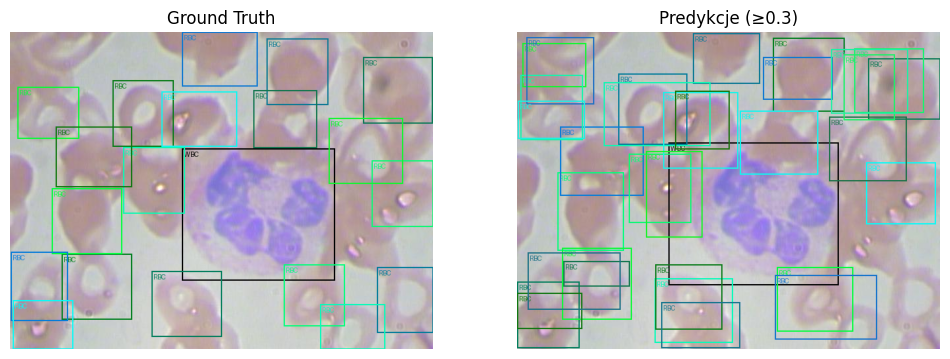

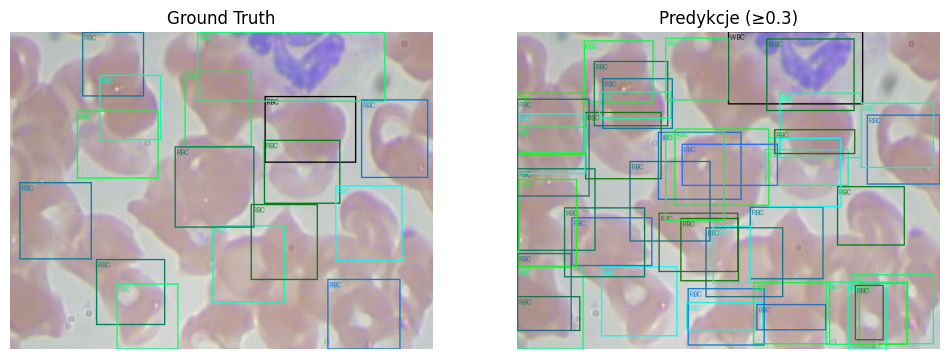

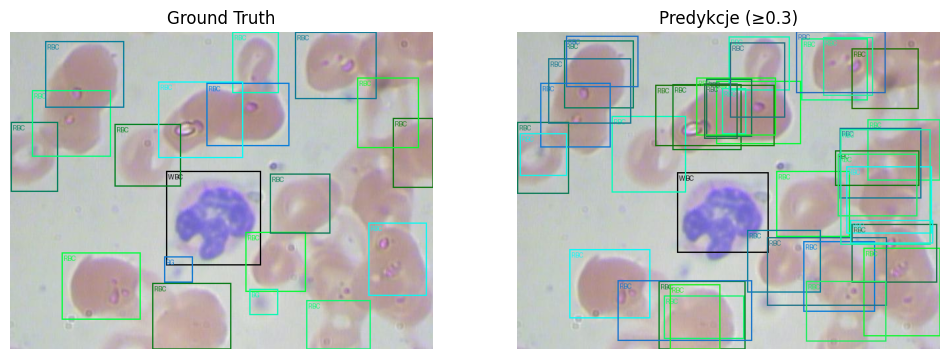

In [ ]:
best_ckpt = Path(ckpt_dir) / Path(Path(ckpt_cb.best_model_path).name)
if best_ckpt.exists():
    print("Wczytuję:", best_ckpt)
    best_model = CustomDetectorLit.load_from_checkpoint(str(best_ckpt), num_classes=NUM_CLASSES, lr=5e-4)
else:
    print("Brak checkpointu; używam bieżącego modelu.")
    best_model = model

best_model.to(device).eval()

@torch.no_grad()
def visualize_predictions(dloader, n=3, score_thresh=0.3):
    imgs, tgts = next(iter(dloader))
    preds = best_model([img.to(device) for img in imgs])
    for i in range(min(n, len(imgs))):
        img = (imgs[i]*255).to(torch.uint8).cpu()
        gt_boxes = tgts[i]["boxes"]
        gt_labels = tgts[i]["labels"].cpu()
        pr_boxes = preds[i]["boxes"].cpu()
        pr_scores = preds[i]["scores"].cpu()
        pr_labels = preds[i]["labels"].cpu()

        keep = pr_scores >= score_thresh
        pr_boxes = pr_boxes[keep]
        pr_labels = pr_labels[keep]

        # labels_txt_gt = ["GT"] * len(gt_boxes)
        labels_txt_gt = [IDX_TO_NAME.get(l.item(), "BG") for l in gt_labels]
        labels_txt_pr = [IDX_TO_NAME.get(l.item(), "BG") for l in pr_labels]

        img_gt = draw_bounding_boxes(img, boxes=gt_boxes, labels=labels_txt_gt, width=2)
        img_pr = draw_bounding_boxes(img, boxes=pr_boxes, labels=labels_txt_pr, width=2)

        plt.figure(figsize=(12,6))
        plt.subplot(1,2,1); plt.imshow(to_pil_image(img_gt)); plt.title("Ground Truth"); plt.axis("off")
        plt.subplot(1,2,2); plt.imshow(to_pil_image(img_pr)); plt.title(f"Predykcje (≥{score_thresh})"); plt.axis("off")
        plt.show()

visualize_predictions(test_loader, n=3, score_thresh=0.3)


---

## Podsumowanie i wnioski

Odpowiedz krótko na poniższe pytania.

1. Wyjaśnij pojęcie **anchor boxes** — po co są używane w sieciach detekcyjnych?
2. Jaką rolę pełni **RPN** (Region Proposal Network) w architekturze sieci detekcyjnej?
3. Wyjaśnij działanie **NMS** (Non-Maximum Suppression) — dlaczego jest używane?